Dataset path: /kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage
Number of classes found: 10
Total images (sum of class folders): 14529

Per-class counts:
  - Tomato___Bacterial_spot                  :  1702
  - Tomato___Early_blight                    :   800
  - Tomato___Late_blight                     :  1527
  - Tomato___Leaf_Mold                       :   761
  - Tomato___Septoria_leaf_spot              :  1417
  - Tomato___Spider_mites Two-spotted_spider_mite :  1341
  - Tomato___Target_Spot                     :  1123
  - Tomato___Tomato_Yellow_Leaf_Curl_Virus   :  4286
  - Tomato___Tomato_mosaic_virus             :   299
  - Tomato___healthy                         :  1273


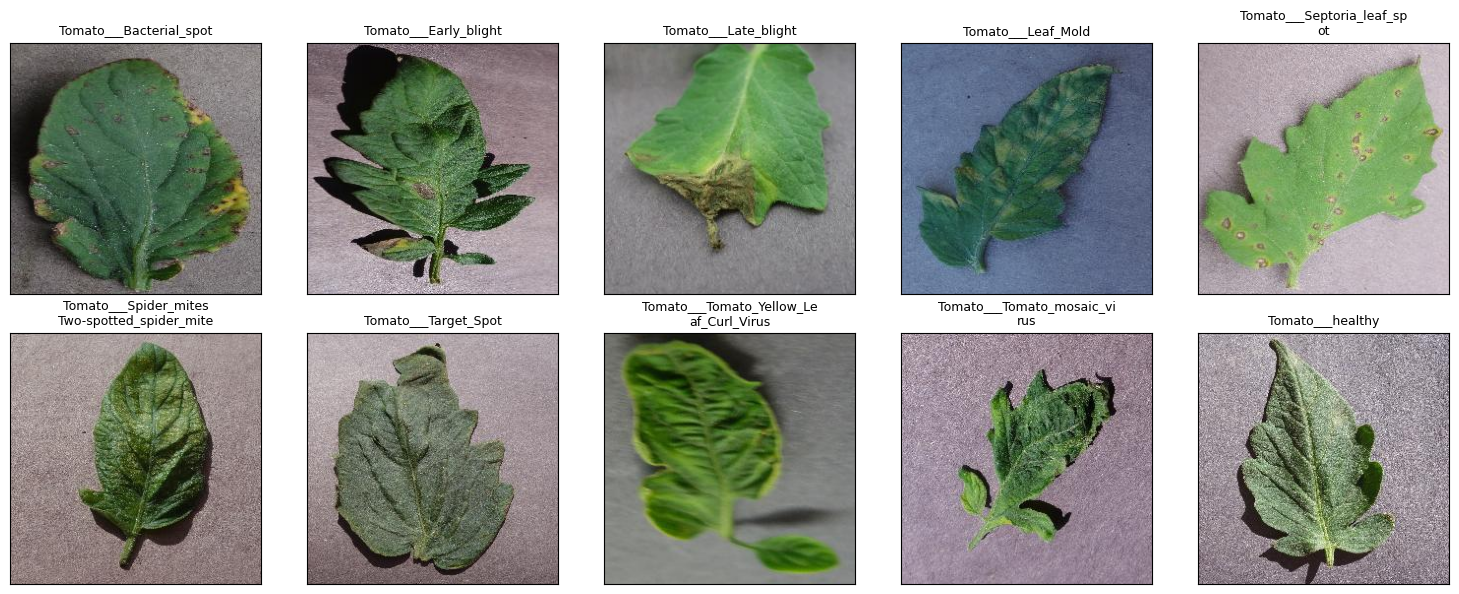

In [ ]:
# ===   show classes & counts, display one sample per class ===
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import textwrap

# dataset 
DATA_DIR = Path("/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage")

assert DATA_DIR.exists(), f"Dataset path does not exist: {DATA_DIR}"

# find class folders  
class_dirs = [p for p in sorted(DATA_DIR.iterdir()) if p.is_dir()]
class_names = [p.name for p in class_dirs]

# compute per-class file counts
counts = {c: len(list((DATA_DIR / c).glob("*.*"))) for c in class_names}
total_images = sum(counts.values())

# print summary
print("Dataset path:", DATA_DIR)
print("Number of classes found:", len(class_names))
print("Total images (sum of class folders):", total_images)
print("\nPer-class counts:")
for c in class_names:
    print(f"  - {c:40s} : {counts[c]:5d}")

# display one random sample image per class (up to 10)
samples = []
for c in class_names:
    files = list((DATA_DIR / c).glob("*.*"))
    if files:
        samples.append(random.choice(files))
    else:
        samples.append(None)

# plot samples  
n = len(samples)
cols = 5
rows = (n + cols - 1) // cols
plt.figure(figsize=(cols*3, rows*3))
for i, fpath in enumerate(samples):
    ax = plt.subplot(rows, cols, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    if fpath is None:
        ax.text(0.5, 0.5, "NO IMAGE", ha="center", va="center")
    else:
        img = mpimg.imread(fpath)
        ax.imshow(img)
        # label under image, wrapped if long
        label = class_names[i]
        ax.set_title("\n".join(textwrap.wrap(label, 25)), fontsize=9)
plt.tight_layout()
plt.show()


In [ ]:
# ===   Split  70% 15% 15% ===
import os
import shutil
import random
from pathlib import Path

random.seed(42)

DATA_DIR = Path("/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage")
OUT_DIR = Path("/kaggle/working/split_data")

#   split if exists
if OUT_DIR.exists():
    shutil.rmtree(OUT_DIR)
OUT_DIR.mkdir()

train_dir = OUT_DIR / "train"
val_dir   = OUT_DIR / "val"
test_dir  = OUT_DIR / "test"

train_dir.mkdir()
val_dir.mkdir()
test_dir.mkdir()

classes = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])

summary = {}

for cls in classes:
    cls_path = DATA_DIR / cls
    images = list(cls_path.glob("*.*"))
    random.shuffle(images)

    n = len(images)
    train_size = int(n * 0.70)
    val_size   = int(n * 0.15)
    test_size  = n - train_size - val_size

    summary[cls] = {
        "total": n,
        "train": train_size,
        "val": val_size,
        "test": test_size
    }

    # create folders
    (train_dir / cls).mkdir()
    (val_dir / cls).mkdir()
    (test_dir / cls).mkdir()

    # copy files
    for i, img in enumerate(images):
        if i < train_size:
            shutil.copy(img, train_dir / cls / img.name)
        elif i < train_size + val_size:
            shutil.copy(img, val_dir / cls / img.name)
        else:
            shutil.copy(img, test_dir / cls / img.name)


# ---- PRINT CLEAN SUMMARY ----
total_train = sum(summary[c]["train"] for c in classes)
total_val   = sum(summary[c]["val"] for c in classes)
total_test  = sum(summary[c]["test"] for c in classes)

print("Train/Val/Test Split Completed!\n")
print(f"Classes found: {len(classes)}\n")

print("Per-class distribution:")
for cls in classes:
    s = summary[cls]
    print(f"{cls:40s}  Total: {s['total']:5d} | Train: {s['train']:5d} | Val: {s['val']:5d} | Test: {s['test']:5d}")

print("\nOverall:")
print(f"  Train images : {total_train}")
print(f"  Val images   : {total_val}")
print(f"  Test images  : {total_test}")

print("\nData saved in:", OUT_DIR)


Train/Val/Test Split Completed!

Classes found: 10

Per-class distribution:
Tomato___Bacterial_spot                   Total:  1702 | Train:  1191 | Val:   255 | Test:   256
Tomato___Early_blight                     Total:   800 | Train:   560 | Val:   120 | Test:   120
Tomato___Late_blight                      Total:  1527 | Train:  1068 | Val:   229 | Test:   230
Tomato___Leaf_Mold                        Total:   761 | Train:   532 | Val:   114 | Test:   115
Tomato___Septoria_leaf_spot               Total:  1417 | Train:   991 | Val:   212 | Test:   214
Tomato___Spider_mites Two-spotted_spider_mite  Total:  1341 | Train:   938 | Val:   201 | Test:   202
Tomato___Target_Spot                      Total:  1123 | Train:   786 | Val:   168 | Test:   169
Tomato___Tomato_Yellow_Leaf_Curl_Virus    Total:  4286 | Train:  3000 | Val:   642 | Test:   644
Tomato___Tomato_mosaic_virus              Total:   299 | Train:   209 | Val:    44 | Test:    46
Tomato___healthy                          Tota

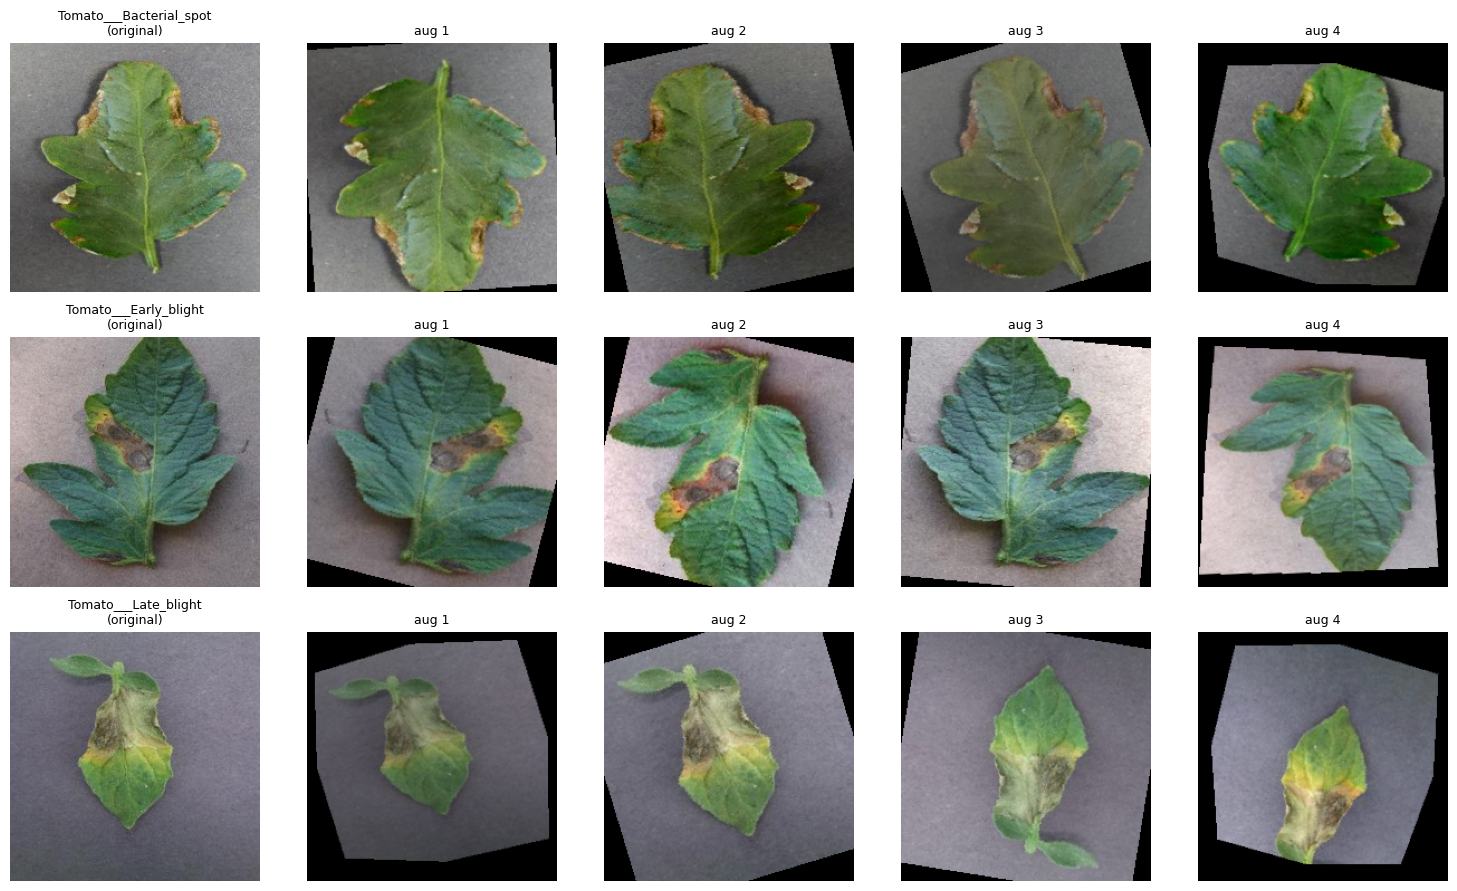

Transforms defined:
 - train_transforms: RandomResizedCrop, H/V flips, ColorJitter, Rotation, Perspective, Normalize
 - val/test_transforms : Resize -> CenterCrop -> Normalize

Preview classes shown (up to 3): ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight']
For each class: displayed original image + 4 augmented versions.


In [ ]:
# ===  Augmentations   ===
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T

random.seed(42)

SPLIT_DIR = Path("/kaggle/working/split_data")
assert SPLIT_DIR.exists(), f"Split directory not found: {SPLIT_DIR}"

# --- Define transforms ---
image_size = 224

train_transforms = T.Compose([
    T.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.2),
    T.RandomApply([T.ColorJitter(brightness=0.3, contrast=0.25, saturation=0.25, hue=0.05)], p=0.7),
    T.RandomRotation(degrees=20),
    T.RandomPerspective(distortion_scale=0.2, p=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transforms = T.Compose([
    T.Resize(int(image_size*1.15)),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_transforms = val_transforms

# --- Helper to un-normalize and show tensor image ---
inv_norm = T.Normalize(
    mean=[-m/s for m, s in zip([0.485,0.456,0.406],[0.229,0.224,0.225])],
    std=[1/s for s in [0.229,0.224,0.225]]
)

def show_tensor_image(tensor, ax=None, title=None):
    if isinstance(tensor, np.ndarray):
        img = tensor
    else:
        # tensor CxHxW  
        img = inv_norm(tensor).clamp(0,1).permute(1,2,0).numpy()
    if ax is None:
        plt.imshow(img); plt.axis('off')
    else:
        ax.imshow(img); ax.axis('off')
        if title:
            ax.set_title(title, fontsize=9)

# --- Choose up to 3 classes for preview  ---
classes = sorted([p.name for p in SPLIT_DIR.joinpath("train").iterdir() if p.is_dir()])
preview_classes = classes[:3]  # first 3 classes (or change indices if you prefer)

 
n_augs = 4
fig_cols = n_augs + 1
fig_rows = len(preview_classes)
plt.figure(figsize=(fig_cols*3, fig_rows*3))

for r, cls in enumerate(preview_classes):
    cls_dir = SPLIT_DIR / "train" / cls
    imgs = list(cls_dir.glob("*.*"))
    if not imgs:
        continue
    sample = random.choice(imgs)
    pil = Image.open(sample).convert("RGB").resize((image_size, image_size))
    # show original
    ax = plt.subplot(fig_rows, fig_cols, r*fig_cols + 1)
    ax.imshow(np.array(pil))
    ax.axis('off')
    ax.set_title(f"{cls}\n(original)", fontsize=9)
    # show augmented variants
    for i in range(n_augs):
        aug = train_transforms(pil)
        ax = plt.subplot(fig_rows, fig_cols, r*fig_cols + 2 + i)
        show_tensor_image(aug, ax=ax, title=f"aug {i+1}")
plt.tight_layout()
plt.show()

# --- Print brief summary for clarity ---
print("Transforms defined:")
print(" - train_transforms: RandomResizedCrop, H/V flips, ColorJitter, Rotation, Perspective, Normalize")
print(" - val/test_transforms : Resize -> CenterCrop -> Normalize")
print()
print("Preview classes shown (up to 3):", preview_classes)
print("For each class: displayed original image + 4 augmented versions.")


In [6]:
# ===   Create PyTorch Dataset & DataLoaders   ===
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

SPLIT_DIR = "/kaggle/working/split_data"

batch_size = 32

train_ds = ImageFolder(root=f"{SPLIT_DIR}/train", transform=train_transforms)
val_ds   = ImageFolder(root=f"{SPLIT_DIR}/val",   transform=val_transforms)
test_ds  = ImageFolder(root=f"{SPLIT_DIR}/test",  transform=test_transforms)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2)

print("DataLoader Summary")
print("---------------------")
print(f"Train samples : {len(train_ds)}")
print(f"Val samples   : {len(val_ds)}")
print(f"Test samples  : {len(test_ds)}")
print()
print(f"Train batches : {len(train_loader)}")
print(f"Val batches   : {len(val_loader)}")
print(f"Test batches  : {len(test_loader)}")
print()

# show one sample batch shape
xb, yb = next(iter(train_loader))
print("One batch input shape :", xb.shape)
print("One batch label shape :", yb.shape)
print("Number of classes     :", len(train_ds.classes))
print("\nClass names:", train_ds.classes)


DataLoader Summary
---------------------
Train samples : 10166
Val samples   : 2175
Test samples  : 2188

Train batches : 318
Val batches   : 68
Test batches  : 69

One batch input shape : torch.Size([32, 3, 224, 224])
One batch label shape : torch.Size([32])
Number of classes     : 10

Class names: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [7]:
# ===   Load pretrained ResNet50  ===
import torch
import torch.nn as nn
import torchvision.models as models

# --- Config ---
num_classes = len(train_ds.classes)   
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- Load pretrained ResNet50 and replace final FC ---
model = models.resnet50(pretrained=True)

 

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)    
model = model.to(device)

# --- Loss, Optimizer, Scheduler ---
criterion = nn.CrossEntropyLoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=3,
                                                       verbose=True)

# --- Print brief summary: params & trainable params ---
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: ResNet50 -> num_classes = {num_classes}")
print(f"Total parameters     : {total_params:,}")
print(f"Trainable parameters : {trainable_params:,}")

# --- Small sanity forward pass to confirm shapes   ---
xb, yb = next(iter(train_loader))
xb = xb.to(device)
with torch.no_grad():
    out = model(xb[:2])   
print("Sanity output shape (batch of 2):", out.shape)  

# --- Save path for best model ---
BEST_MODEL_PATH = "/kaggle/working/best_resnet50.pth"
print("Will save best model to:", BEST_MODEL_PATH)


Device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s] 


Model: ResNet50 -> num_classes = 10
Total parameters     : 23,528,522
Trainable parameters : 23,528,522


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Sanity output shape (batch of 2): torch.Size([2, 10])
Will save best model to: /kaggle/working/best_resnet50.pth


In [8]:
# ===  Training Loop  ===
import torch
import numpy as np
import time

max_epochs = 40
early_patience = 6

best_val_loss = np.inf
epochs_no_improve = 0

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

print("Starting training...\n")

for epoch in range(1, max_epochs + 1):
    start_time = time.time()

    # --- TRAIN ---
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_loss /= total
    train_acc = correct / total

    # --- VALIDATION ---
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)

            val_loss += loss.item() * xb.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    val_loss /= total
    val_acc = correct / total

    # --- Record history ---
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # --- Scheduler ---
    scheduler.step(val_loss)

    # --- Print epoch result ---
    elapsed = time.time() - start_time
    print(f"Epoch {epoch:02d}/{max_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")

    # --- Early Stopping Check ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print("  --> Saved best model")
    else:
        epochs_no_improve += 1
        print(f"  --> No improvement ({epochs_no_improve}/{early_patience})")

    if epochs_no_improve >= early_patience:
        print("\nEarly stopping triggered!")
        break

print("\nTraining completed.")
print("Best model saved at:", BEST_MODEL_PATH)


Starting training...

Epoch 01/40 | Train Loss: 0.3451 | Train Acc: 0.8904 | Val Loss: 0.0570 | Val Acc: 0.9867 | Time: 114.0s
  --> Saved best model
Epoch 02/40 | Train Loss: 0.1257 | Train Acc: 0.9585 | Val Loss: 0.0666 | Val Acc: 0.9766 | Time: 115.5s
  --> No improvement (1/6)
Epoch 03/40 | Train Loss: 0.0869 | Train Acc: 0.9721 | Val Loss: 0.0679 | Val Acc: 0.9784 | Time: 115.8s
  --> No improvement (2/6)
Epoch 04/40 | Train Loss: 0.0705 | Train Acc: 0.9782 | Val Loss: 0.0300 | Val Acc: 0.9917 | Time: 115.7s
  --> Saved best model
Epoch 05/40 | Train Loss: 0.0615 | Train Acc: 0.9811 | Val Loss: 0.0362 | Val Acc: 0.9885 | Time: 115.7s
  --> No improvement (1/6)
Epoch 06/40 | Train Loss: 0.0579 | Train Acc: 0.9808 | Val Loss: 0.0362 | Val Acc: 0.9908 | Time: 115.6s
  --> No improvement (2/6)
Epoch 07/40 | Train Loss: 0.0562 | Train Acc: 0.9815 | Val Loss: 0.0719 | Val Acc: 0.9761 | Time: 115.5s
  --> No improvement (3/6)
Epoch 08/40 | Train Loss: 0.0474 | Train Acc: 0.9841 | Val Los

/tmp/ipykernel_48/3289944749.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


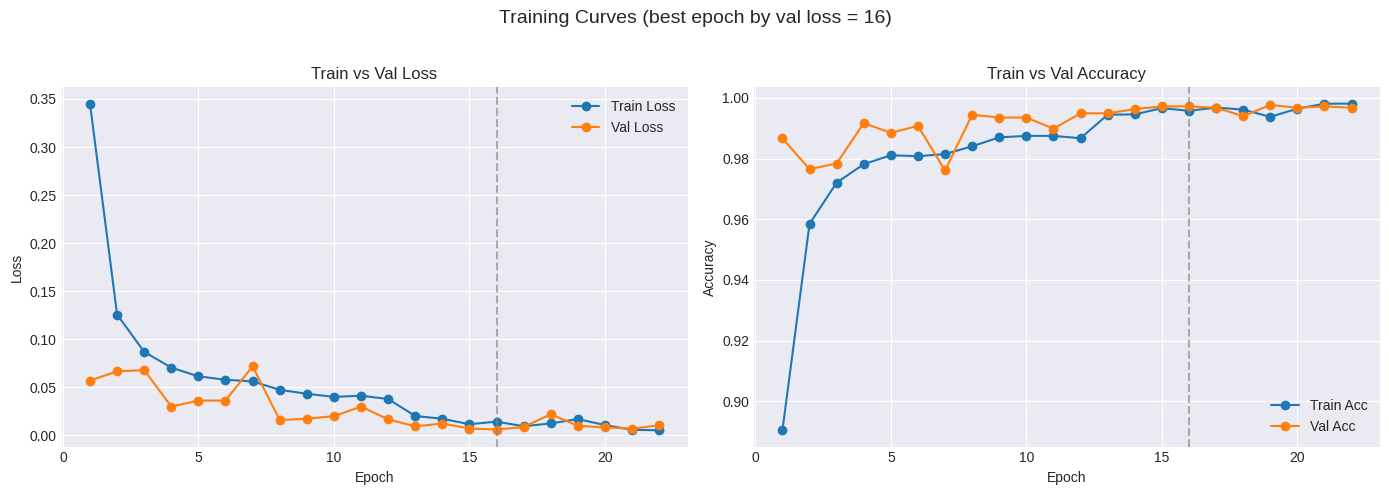

Best epoch (by val loss): 16
  Best val loss : 0.0061
  Train acc @best epoch : 0.9958
  Val acc   @best epoch : 0.9972

Saved plot to: /kaggle/working/training_curves.png


In [ ]:
# === Plot Training / Validation Loss & Accuracy ===
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

 
assert "history" in globals(), "Run Cell 6 (training) first to populate `history`."

train_loss = history["train_loss"]
val_loss   = history["val_loss"]
train_acc  = history["train_acc"]
val_acc    = history["val_acc"]

epochs = np.arange(1, len(train_loss) + 1)

# find best epoch 
best_idx = int(np.argmin(val_loss)) if len(val_loss) > 0 else 0
best_epoch = best_idx + 1
best_val = val_loss[best_idx] if len(val_loss) > 0 else None
best_train_acc = train_acc[best_idx] if len(train_acc) > 0 else None
best_val_acc = val_acc[best_idx] if len(val_acc) > 0 else None

plt.style.use('seaborn-darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Loss plot
axes[0].plot(epochs, train_loss, marker='o', label='Train Loss')
axes[0].plot(epochs, val_loss,   marker='o', label='Val Loss')
axes[0].axvline(best_epoch, color='gray', linestyle='--', alpha=0.6)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train vs Val Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(epochs, train_acc, marker='o', label='Train Acc')
axes[1].plot(epochs, val_acc,   marker='o', label='Val Acc')
axes[1].axvline(best_epoch, color='gray', linestyle='--', alpha=0.6)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Train vs Val Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.suptitle(f"Training Curves (best epoch by val loss = {best_epoch})", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])

# save & show
out_path = Path("/kaggle/working/training_curves.png")
fig.savefig(out_path, dpi=150)
plt.show()

# print concise summary
print(f"Best epoch (by val loss): {best_epoch}")
if best_val is not None:
    print(f"  Best val loss : {best_val:.4f}")
if best_train_acc is not None and best_val_acc is not None:
    print(f"  Train acc @best epoch : {best_train_acc:.4f}")
    print(f"  Val acc   @best epoch : {best_val_acc:.4f}")

print("\nSaved plot to:", out_path)


In [12]:
# ===   Load best model + classification report + confusion matrix ===
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load best model ---
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.eval()
print("Loaded best model from:", BEST_MODEL_PATH)

all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# --- Classification Report ---
target_names = train_ds.classes
report = classification_report(all_labels, all_preds, target_names=target_names)
print("\n===== Classification Report =====\n")
print(report)

print("Evaluation complete!")


Loaded best model from: /kaggle/working/best_resnet50.pth

===== Classification Report =====

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.99      0.99      0.99       256
                        Tomato___Early_blight       0.99      0.98      0.99       120
                         Tomato___Late_blight       0.99      1.00      1.00       230
                           Tomato___Leaf_Mold       0.99      1.00      1.00       115
                  Tomato___Septoria_leaf_spot       1.00      0.98      0.99       214
Tomato___Spider_mites Two-spotted_spider_mite       0.99      1.00      1.00       202
                         Tomato___Target_Spot       0.99      0.99      0.99       169
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      1.00      1.00       644
                 Tomato___Tomato_mosaic_virus       1.00      1.00      1.00        46
                             Tomato

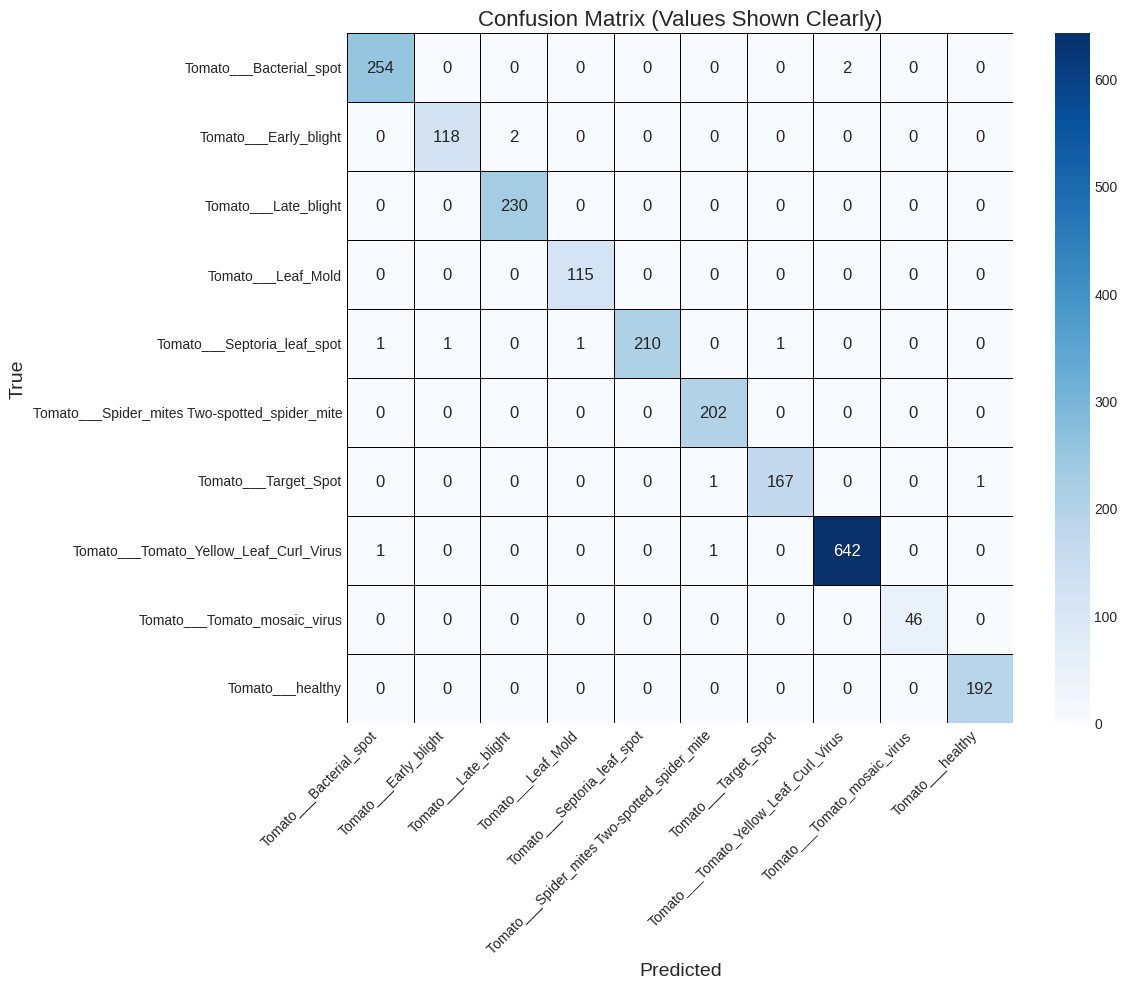

In [11]:
# ===  Confusion Matrix  ===
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True,         
    fmt="d",            
    cmap="Blues",
    cbar=True,
    linewidths=0.5,
    linecolor="black",
    annot_kws={"size": 12}   
)

plt.title("Confusion Matrix (Values Shown Clearly)", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(ticks=np.arange(len(target_names))+0.5, labels=target_names, rotation=45, ha="right", fontsize=10)
plt.yticks(ticks=np.arange(len(target_names))+0.5, labels=target_names, rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


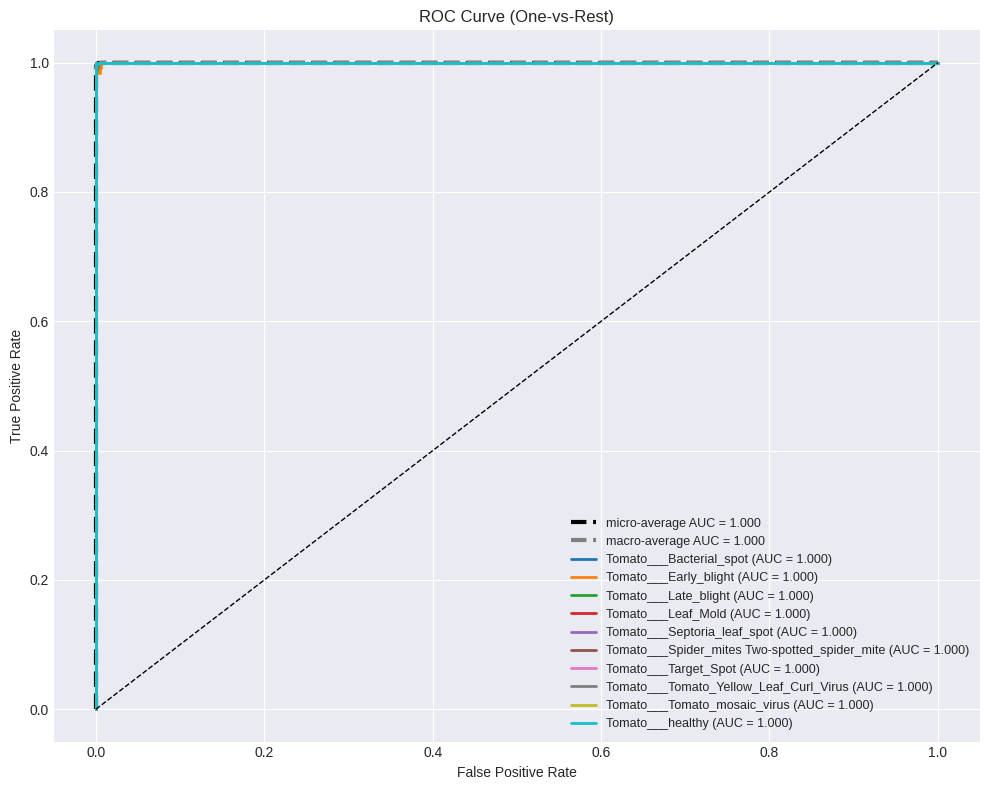

ROC curve plotted for all classes.


In [14]:
# ===   ROC Curve ===
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

model.eval()

# --- collect probabilities and labels ---
all_probs = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        all_probs.append(probs)
        all_labels.append(yb.numpy())

all_probs = np.vstack(all_probs)
all_labels = np.hstack(all_labels)

num_classes = len(target_names)

# --- binarize labels for one-vs-rest ROC ---
y_bin = label_binarize(all_labels, classes=np.arange(num_classes))

# --- compute per-class ROC & AUC ---
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- micro & macro average ---
# micro
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# --- Plot ---
plt.figure(figsize=(10, 8))

# plot micro & macro first
plt.plot(fpr["micro"], tpr["micro"],
         label=f"micro-average AUC = {roc_auc['micro']:.3f}",
         linestyle="--", linewidth=3, color="black")

plt.plot(fpr["macro"], tpr["macro"],
         label=f"macro-average AUC = {roc_auc['macro']:.3f}",
         linestyle="--", linewidth=3, color="gray")

# per-class ROC curves
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{target_names[i]} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(fontsize=9, loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

print("ROC curve plotted for all classes.")


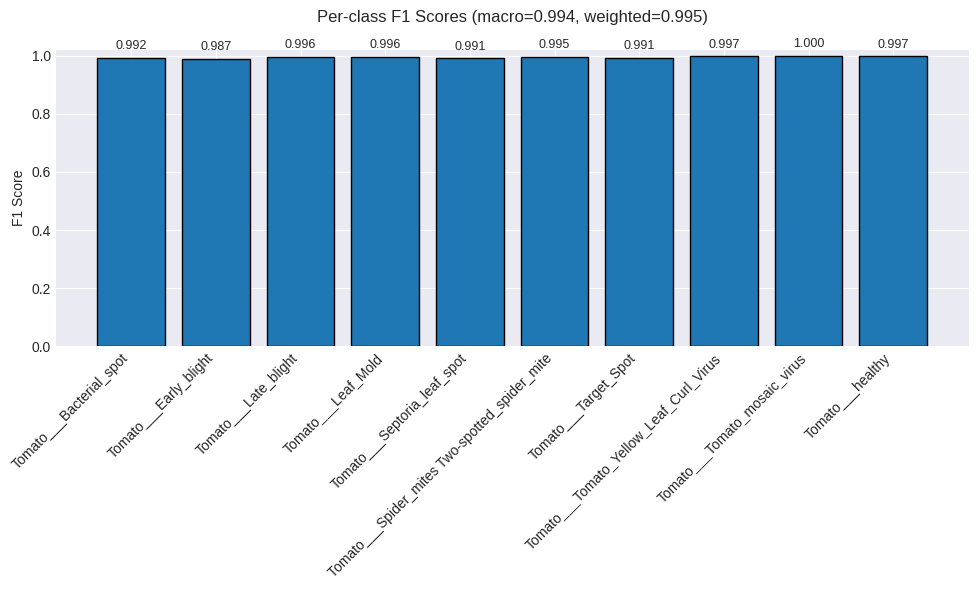

Saved F1 bar chart to: /kaggle/working/f1_scores.png

===== F1 SCORE SUMMARY =====

=====   =====
F1 Macro     : 0.9942
F1 Micro     : 0.9945
F1 Weighted  : 0.9945

Per-Class F1 Scores:
  Tomato___Bacterial_spot             : 0.9922
  Tomato___Early_blight               : 0.9874
  Tomato___Late_blight                : 0.9957
  Tomato___Leaf_Mold                  : 0.9957
  Tomato___Septoria_leaf_spot         : 0.9906
  Tomato___Spider_mites Two-spotted_spider_mite : 0.9951
  Tomato___Target_Spot                : 0.9911
  Tomato___Tomato_Yellow_Leaf_Curl_Virus : 0.9969
  Tomato___Tomato_mosaic_virus        : 1.0000
  Tomato___healthy                    : 0.9974


In [23]:
# ===  F1  scores ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

 
assert 'all_labels' in globals() and 'all_preds' in globals(), "Run evaluation (Cell 8) first to produce all_labels & all_preds."
assert 'train_ds' in globals() and hasattr(train_ds, "classes"), "Run DataLoader cell (Cell 4) first to create train_ds."

target_names = train_ds.classes  

# --- compute F1 scores ---
f1_per_class = f1_score(all_labels, all_preds, average=None, labels=range(len(target_names)))
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_micro = f1_score(all_labels, all_preds, average='micro')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')

# --- Plot per-class F1 as a bar chart ---
plt.figure(figsize=(10,6))
x = np.arange(len(target_names))
bars = plt.bar(x, f1_per_class, edgecolor='black')
plt.ylim(0, 1.02)
plt.xticks(x, target_names, rotation=45, ha='right')
plt.ylabel('F1 Score')

# Added gap in title using pad=
plt.title(f'Per-class F1 Scores (macro={f1_macro:.3f}, weighted={f1_weighted:.3f})', pad=20)

# annotate bars with numeric values
for bar, val in zip(bars, f1_per_class):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{val:.3f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
out_path = "/kaggle/working/f1_scores.png"
plt.savefig(out_path, dpi=150)
plt.show()

print("Saved F1 bar chart to:", out_path)
print("\n===== F1 SCORE SUMMARY =====")
print("\n=====   =====")
print(f"F1 Macro     : {f1_macro:.4f}")
print(f"F1 Micro     : {f1_micro:.4f}")
print(f"F1 Weighted  : {f1_weighted:.4f}")
print("\nPer-Class F1 Scores:")
for cls_name, f1v in zip(target_names, f1_per_class):
    print(f"  {cls_name:35s} : {f1v:.4f}")


Total misclassified images: 12


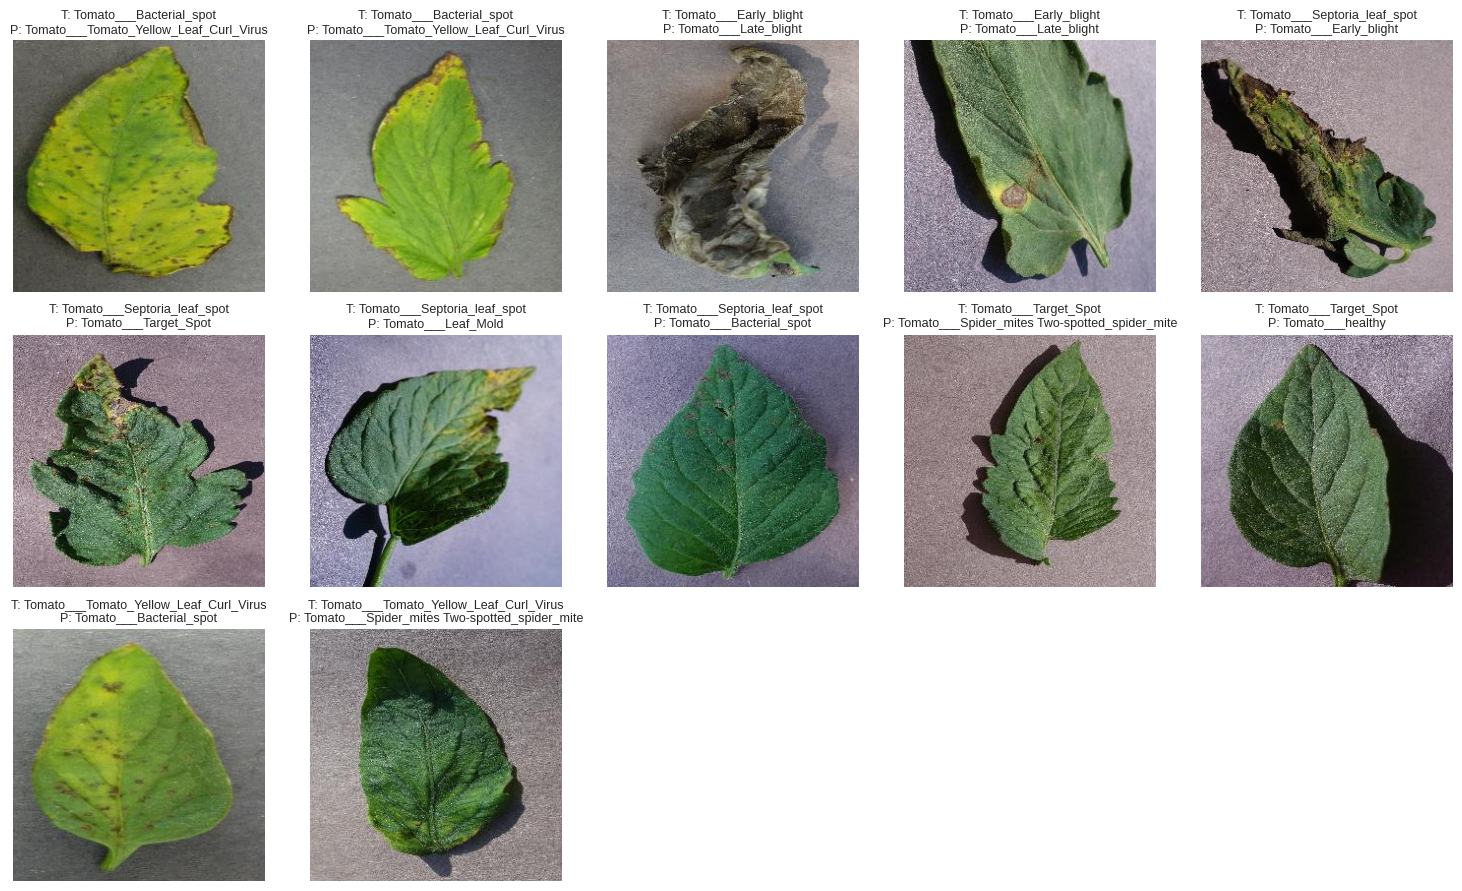

In [24]:
# === Show Misclassified Images  ===
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from torchvision import transforms
from PIL import Image

# make sure we have predictions
assert "all_preds" in globals() and "all_labels" in globals(), "Run Cell 8 first."

# collect test image file paths
test_root = Path("/kaggle/working/split_data/test")
test_files = []
test_targets = []

for cls_idx, cls_name in enumerate(target_names):
    cls_folder = test_root / cls_name
    for f in cls_folder.glob("*.*"):
        test_files.append(str(f))
        test_targets.append(cls_idx)

test_files = np.array(test_files)
test_targets = np.array(test_targets)

# re-run model on test set to align predictions with file order
model.eval()
pred_list = []

with torch.no_grad():
    for filepath in test_files:
        img = Image.open(filepath).convert("RGB")
        img = test_transforms(img).unsqueeze(0).to(device)
        out = model(img)
        _, pred = torch.max(out, 1)
        pred_list.append(pred.item())

pred_list = np.array(pred_list)

# find misclassified indices
mis_idx = np.where(pred_list != test_targets)[0]
print(f"Total misclassified images: {len(mis_idx)}")

# limit to 20 max for clean display
mis_idx = mis_idx[:20]

# plot
cols = 5
rows = int(np.ceil(len(mis_idx) / cols))
plt.figure(figsize=(cols*3, rows*3))

for i, idx in enumerate(mis_idx):
    img_path = test_files[idx]
    true_label = target_names[test_targets[idx]]
    pred_label = target_names[pred_list[idx]]

    img = Image.open(img_path).convert("RGB")

    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(img)
    ax.set_title(f"T: {true_label}\nP: {pred_label}", fontsize=9)
    ax.axis("off")

plt.tight_layout()
plt.show()


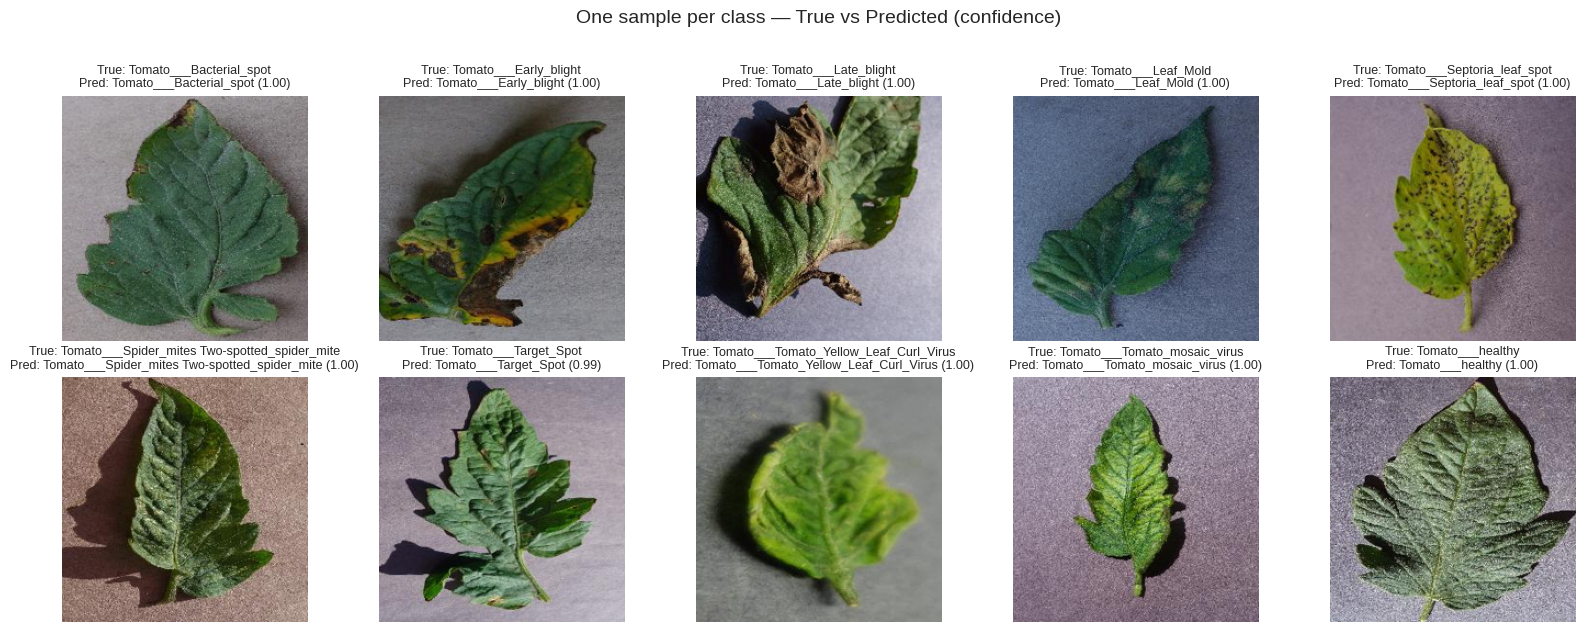


Summary (one sample per class):
Tomato___Bacterial_spot             : Predicted -> Tomato___Bacterial_spot        Confidence -> 1.000  (file: 88cc038d-6215-45de-a0e7-26cb701e96e2___GCREC_Bact.Sp 3494.JPG)
Tomato___Early_blight               : Predicted -> Tomato___Early_blight          Confidence -> 1.000  (file: 64fade29-cabf-4ec2-a5cf-8c7aeca19eea___RS_Erly.B 6427.JPG)
Tomato___Late_blight                : Predicted -> Tomato___Late_blight           Confidence -> 1.000  (file: cbf0f139-7683-47f8-a107-4180deee217e___RS_Late.B 6029.JPG)
Tomato___Leaf_Mold                  : Predicted -> Tomato___Leaf_Mold             Confidence -> 1.000  (file: e401be04-ce62-4682-ae91-765fc4c2cc31___Crnl_L.Mold 7114.JPG)
Tomato___Septoria_leaf_spot         : Predicted -> Tomato___Septoria_leaf_spot    Confidence -> 1.000  (file: 73fea91d-3582-461b-8aec-236c78f6b1cd___Matt.S_CG 0799.JPG)
Tomato___Spider_mites Two-spotted_spider_mite : Predicted -> Tomato___Spider_mites Two-spotted_spider_mite Confidenc

In [25]:
# ===  One sample per class  ===
import random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from PIL import Image
import numpy as np
import torch.nn.functional as F

# Paths
test_root = Path("/kaggle/working/split_data/test")
assert test_root.exists(), "Run splitting cell (Cell 2) first."

# sanity
assert 'model' in globals(), "Run model cell (Cell 5) first."
assert 'test_transforms' in globals(), "Run transforms cell (Cell 3) first."
assert 'target_names' in globals(), "Run DataLoader cell (Cell 4) first."

model.eval()

# choose one sample per class from test set (fallback to train if test empty)
samples = []
for cls in target_names:
    cls_folder = test_root / cls
    imgs = list(cls_folder.glob("*.*"))
    if not imgs:
        # fallback to train folder
        imgs = list(Path("/kaggle/working/split_data/train").joinpath(cls).glob("*.*"))
    if imgs:
        samples.append(random.choice(imgs))
    else:
        samples.append(None)

# Plot grid
n = len(samples)
cols = 5
rows = (n + cols - 1) // cols
plt.figure(figsize=(cols*3.2, rows*3.2))

for i, fpath in enumerate(samples):
    ax = plt.subplot(rows, cols, i+1)
    ax.axis("off")
    cls_name = target_names[i]
    if fpath is None:
        ax.text(0.5, 0.5, "NO IMAGE", ha="center", va="center")
        ax.set_title(cls_name, fontsize=9)
        continue

    # load and preprocess
    img = Image.open(fpath).convert("RGB")
    inp = test_transforms(img).unsqueeze(0).to(device)

    # predict
    with torch.no_grad():
        out = model(inp)
        probs = F.softmax(out, dim=1).cpu().numpy()[0]
        pred_idx = int(probs.argmax())
        pred_name = target_names[pred_idx]
        conf = float(probs[pred_idx])

    # show image
    ax.imshow(np.array(img.resize((224,224))))
    title = f"True: {cls_name}\nPred: {pred_name} ({conf:.2f})"
    ax.set_title(title, fontsize=9)

plt.suptitle("One sample per class — True vs Predicted (confidence)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# print a concise text summary
print("\nSummary (one sample per class):")
for i, fpath in enumerate(samples):
    cls_name = target_names[i]
    if fpath is None:
        print(f"{cls_name:35s} : NO IMAGE")
        continue
    img = Image.open(fpath).convert("RGB")
    inp = test_transforms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(inp)
        probs = F.softmax(out, dim=1).cpu().numpy()[0]
        pred_idx = int(probs.argmax())
        pred_name = target_names[pred_idx]
        conf = float(probs[pred_idx])
    print(f"{cls_name:35s} : Predicted -> {pred_name:30s} Confidence -> {conf:.3f}  (file: {fpath.name})")
